<a href="https://colab.research.google.com/github/Ana-Beatriz26/T-picos-Especiais-em-Estat-stica-Computacional/blob/main/redes_neurais_c%C3%A2ncer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tarekmasryo/cancer-risk-factors-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cancer-risk-factors-dataset' dataset.
Path to dataset files: /kaggle/input/cancer-risk-factors-dataset


In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Caminho dos arquivos baixados
print(path)

/kaggle/input/cancer-risk-factors-dataset


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [4]:
pip install scikeras


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline   # pipeline que aceita SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, RMSprop

from scikeras.wrappers import KerasClassifier


In [6]:
os.listdir(path)


['cancer-risk-factors.csv']

In [7]:
df = pd.read_csv(os.path.join(path, "cancer-risk-factors.csv"))


In [8]:
df.head()

,Patient_ID,Cancer_Type,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,...,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level,Risk_Level
0,LU0000,Breast,68,0,7,2,8,0,5,3,...,4,6,3,1,0,0,0.398696,28.0,5,Medium
1,LU0001,Prostate,74,1,8,9,8,0,0,3,...,1,3,3,0,0,5,0.424299,25.4,9,Medium
2,LU0002,Skin,55,1,7,10,7,0,3,3,...,1,8,10,0,0,6,0.605082,28.6,2,Medium
3,LU0003,Colon,61,0,6,2,2,0,6,2,...,6,4,8,0,0,8,0.318449,32.1,7,Low
4,LU0004,Lung,67,1,10,7,4,0,6,3,...,9,10,9,0,0,5,0.524358,25.1,2,Medium


In [8]:
df.nunique()

,0
Patient_ID,2000
Cancer_Type,5
Age,61
Gender,2
Smoking,11
Alcohol_Use,11
Obesity,11
Family_History,2
Diet_Red_Meat,11
Diet_Salted_Processed,11


In [9]:
## Observando as informações gerais

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               2000 non-null   object 
 1   Cancer_Type              2000 non-null   object 
 2   Age                      2000 non-null   int64  
 3   Gender                   2000 non-null   int64  
 4   Smoking                  2000 non-null   int64  
 5   Alcohol_Use              2000 non-null   int64  
 6   Obesity                  2000 non-null   int64  
 7   Family_History           2000 non-null   int64  
 8   Diet_Red_Meat            2000 non-null   int64  
 9   Diet_Salted_Processed    2000 non-null   int64  
 10  Fruit_Veg_Intake         2000 non-null   int64  
 11  Physical_Activity        2000 non-null   int64  
 12  Air_Pollution            2000 non-null   int64  
 13  Occupational_Hazards     2000 non-null   int64  
 14  BRCA_Mutation           

Temos apenas 3 colunas em formato de objeto que precisarão ser trasformadas para ser utilizadas em redes neurais.

In [10]:
df.describe()


,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,Fruit_Veg_Intake,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.00000,2000.000000,2000.000000,2000.000000
mean,63.248000,0.489000,5.157000,5.035000,5.967500,0.194500,5.189500,4.563500,4.927500,4.015000,5.323000,4.979000,0.032500,0.19650,3.94050,0.454449,26.183350,4.938500
std,10.462946,0.500004,3.325339,3.260996,3.061393,0.395914,3.154452,3.088323,3.045305,2.978458,3.207462,3.212899,0.177368,0.39745,3.04887,0.123074,3.947459,3.166027
min,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.029285,15.000000,0.000000
25%,56.000000,0.000000,2.000000,2.000000,4.000000,0.000000,3.000000,2.000000,3.000000,1.000000,3.000000,2.000000,0.000000,0.00000,1.00000,0.366982,23.500000,2.000000
50%,64.000000,0.000000,5.000000,5.000000,6.000000,0.000000,5.000000,4.000000,5.000000,4.000000,5.000000,5.000000,0.000000,0.00000,4.00000,0.455399,26.200000,5.000000
75%,70.000000,1.000000,8.000000,8.000000,9.000000,0.000000,8.000000,7.000000,8.000000,6.000000,8.000000,8.000000,0.000000,0.00000,6.00000,0.539782,28.700000,8.000000
max,90.000000,1.000000,10.000000,10.000000,10.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.00000,10.00000,0.852158,41.400000,10.000000


In [11]:
df.describe(include="object")


,Patient_ID,Cancer_Type,Risk_Level
count,2000,2000,2000
unique,2000,5,3
top,LU0000,Lung,Medium
freq,1,527,1574


In [12]:
df.isna().sum()


,0
Patient_ID,0
Cancer_Type,0
Age,0
Gender,0
Smoking,0
Alcohol_Use,0
Obesity,0
Family_History,0
Diet_Red_Meat,0
Diet_Salted_Processed,0


In [ ]:
## A variável alvo será o risco de câncer, para avaliar se é baixo, médio ou alto. ##

Não temos valores ausentes, isso é ótimo

In [9]:
## variáveis numericas
df[["Age","Fruit_Veg_Intake","Air_Pollution",
    "Calcium_Intake","BMI","Overall_Risk_Score"]].describe()


,Age,Fruit_Veg_Intake,Air_Pollution,Calcium_Intake,BMI,Overall_Risk_Score
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000
mean,63.248000,4.927500,5.323000,3.94050,26.183350,0.454449
std,10.462946,3.045305,3.207462,3.04887,3.947459,0.123074
min,25.000000,0.000000,0.000000,0.00000,15.000000,0.029285
25%,56.000000,3.000000,3.000000,1.00000,23.500000,0.366982
50%,64.000000,5.000000,5.000000,4.00000,26.200000,0.455399
75%,70.000000,8.000000,8.000000,6.00000,28.700000,0.539782
max,90.000000,10.000000,10.000000,10.00000,41.400000,0.852158


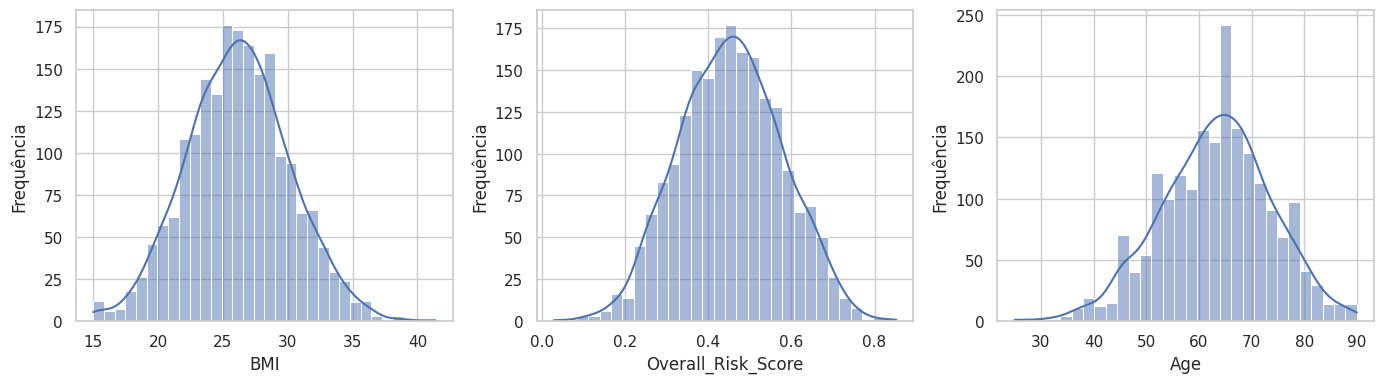

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# estilo mais bonito
sns.set(style="whitegrid")

# lista das variáveis
variaveis = ["BMI", "Overall_Risk_Score", "Age"]

plt.figure(figsize=(14, 4))

for i, var in enumerate(variaveis, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[var], kde=True)
    plt.xlabel(var)
    plt.ylabel("Frequência")

plt.tight_layout()

# salvar figura
plt.savefig("distribuicoes_variaveis.png", dpi=300, bbox_inches='tight')

plt.show()


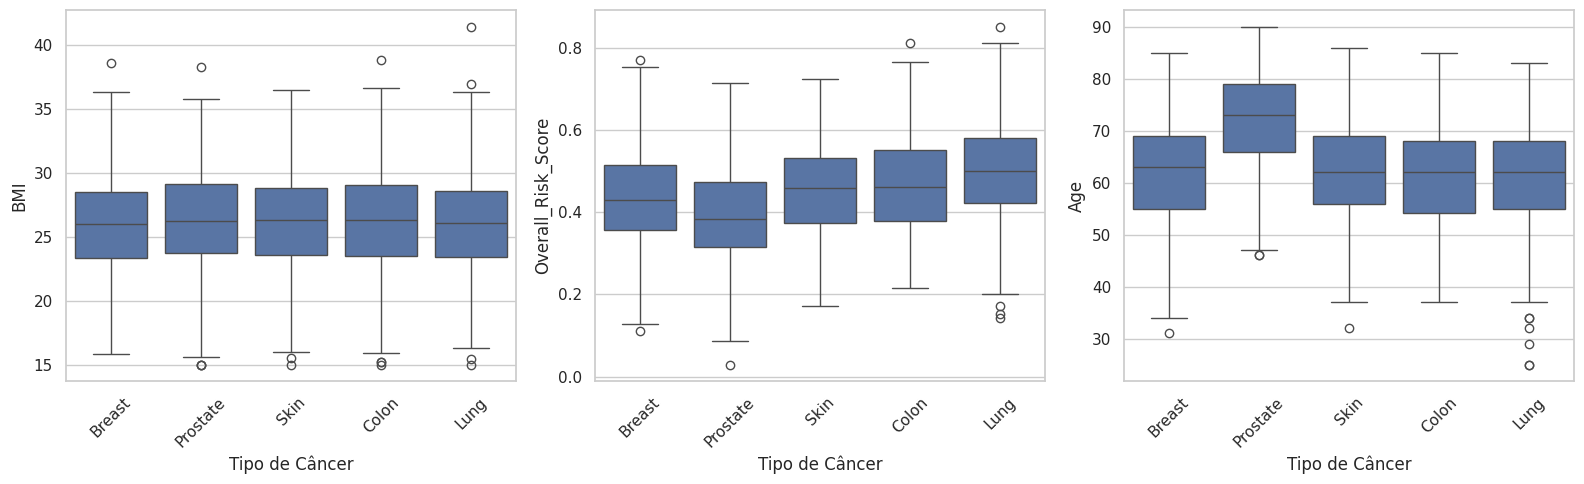

In [11]:

sns.set(style="whitegrid")

variaveis = ["BMI", "Overall_Risk_Score", "Age"]

plt.figure(figsize=(16, 5))

for i, var in enumerate(variaveis, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x="Cancer_Type", y=var)
    plt.xlabel("Tipo de Câncer")
    plt.ylabel(var)
    plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig("relacao_variaveis_cancer_type.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
## avaliando as categoricas

for col in ["Cancer_Type","Risk_Level","Gender","Smoking","Physical_Activity_Level"]:
    print("\nDistribuição de", col)
    print(df[col].value_counts())



Distribuição de Cancer_Type
Cancer_Type
Lung        527
Breast      460
Colon       418
Prostate    305
Skin        290
Name: count, dtype: int64

Distribuição de Risk_Level
Risk_Level
Medium    1574
Low        324
High       102
Name: count, dtype: int64

Distribuição de Gender
Gender
0    1022
1     978
Name: count, dtype: int64

Distribuição de Smoking
Smoking
10    343
6     267
1     204
3     175
2     174
0     169
5     166
4     166
9     126
8     107
7     103
Name: count, dtype: int64

Distribuição de Physical_Activity_Level
Physical_Activity_Level
0     214
5     204
7     195
9     191
2     188
6     177
3     172
4     171
8     166
10    165
1     157
Name: count, dtype: int64


In [13]:
df.corr(numeric_only=True)


,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,Fruit_Veg_Intake,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level
Age,1.000000,0.283851,0.037255,-0.033405,-0.012820,0.034240,-0.045486,-0.056979,0.001993,0.071170,-0.020350,0.043489,-0.026180,0.016786,0.065950,-0.036230,-0.008940,-0.044421
Gender,0.283851,1.000000,0.110856,-0.061739,-0.194849,0.014604,0.033832,0.024912,0.010153,0.041092,0.029978,0.064316,-0.077758,-0.013032,0.304259,0.002985,0.024175,-0.051779
Smoking,0.037255,0.110856,1.000000,0.115146,-0.089129,0.003012,-0.145860,-0.058645,0.043312,0.105324,0.456007,-0.011725,-0.040885,-0.052877,0.080510,0.433407,0.002970,0.020351
Alcohol_Use,-0.033405,-0.061739,0.115146,1.000000,0.003371,0.006349,-0.022529,-0.028733,0.036878,0.041304,0.072620,-0.001076,-0.041753,-0.052011,-0.064294,0.391402,-0.011920,0.017264
Obesity,-0.012820,-0.194849,-0.089129,0.003371,1.000000,0.013473,-0.047693,-0.035258,0.014718,0.008338,-0.068879,0.003287,0.055381,0.019230,-0.108524,0.228454,0.005941,0.016568
Family_History,0.034240,0.014604,0.003012,0.006349,0.013473,1.000000,-0.001088,-0.011538,-0.007799,-0.002051,0.002109,0.022876,0.009671,-0.017289,0.041088,0.059858,0.024095,0.060631
Diet_Red_Meat,-0.045486,0.033832,-0.145860,-0.022529,-0.047693,-0.001088,1.000000,0.180107,-0.191508,0.002785,-0.077102,-0.009923,-0.019954,0.020160,0.101093,0.277150,0.031621,0.033726
Diet_Salted_Processed,-0.056979,0.024912,-0.058645,-0.028733,-0.035258,-0.011538,0.180107,1.000000,-0.218043,-0.021966,0.037471,0.059978,0.046916,0.139604,0.059029,0.365064,-0.005841,-0.004077
Fruit_Veg_Intake,0.001993,0.010153,0.043312,0.036878,0.014718,-0.007799,-0.191508,-0.218043,1.000000,0.012640,-0.043439,-0.050772,-0.032681,-0.146521,-0.021693,-0.148192,-0.006601,-0.011047
Physical_Activity,0.071170,0.041092,0.105324,0.041304,0.008338,-0.002051,0.002785,-0.021966,0.012640,1.000000,0.084794,0.003849,0.008546,-0.023620,0.001255,0.067869,0.008297,0.028267


A idade média é de 63 anos. O valor médio do BMI indica sobre peso leve. O câncer de pele é o menos frequente, enquanto o de pulmão lidera o ranking. A variável resposta está desbalanceada, a quantidade de pacientes com risco médio é muito superior as demais.

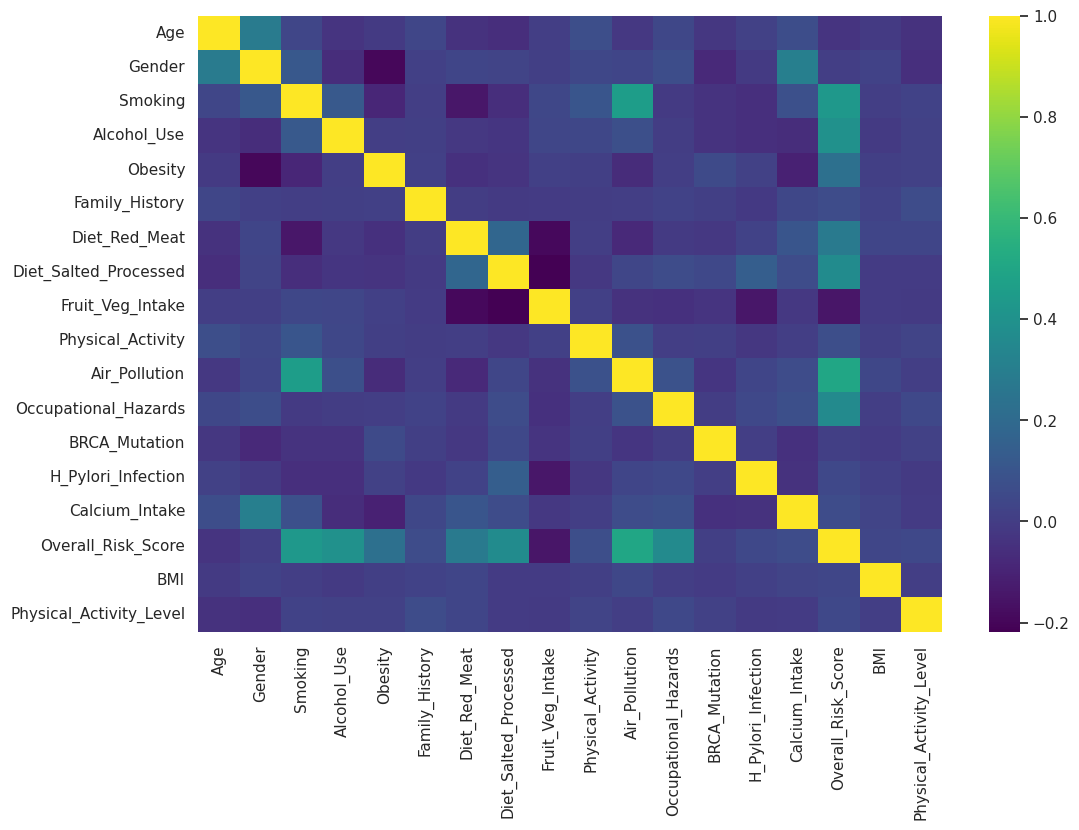

In [18]:
## Avaliando a correlação com a variável alvo



corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap="viridis")
plt.show()

In [14]:
## apagar a coluna ID que não trás informações

df = df.drop(columns=["Patient_ID"])


In [15]:
## separando a variável alvo das demais
y = df["Risk_Level"]
X = df.drop(columns=["Risk_Level"])

In [16]:
## codificando a variável alvo
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [17]:
categorical_cols = ["Cancer_Type"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [18]:
## fazendo as transformações nas variáveis númericas e categoricas

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)


In [19]:
X_processed = preprocessor.fit_transform(X)


In [20]:
## separando as variáveis em treino e teste

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_cat,
    test_size=0.20,
    random_state=42,
    stratify=y_cat
)

In [58]:
# 8. Construção do modelo
model = Sequential()

# Camada densa 1
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))   # evitar overfitting

# Camada densa 2
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Camada de saída (classes do Risk_Level)
model.add(Dense(y_cat.shape[1], activation='softmax'))

# Compilação
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 9. Treinamento do modelo
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5288 - loss: 0.9794 - val_accuracy: 0.7688 - val_loss: 0.6738
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8033 - loss: 0.6447 - val_accuracy: 0.8031 - val_loss: 0.5625
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8185 - loss: 0.5372 - val_accuracy: 0.8281 - val_loss: 0.4933
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8409 - loss: 0.4666 - val_accuracy: 0.8375 - val_loss: 0.4413
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8456 - loss: 0.4345 - val_accuracy: 0.8500 - val_loss: 0.3928
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - loss: 0.3712 - val_accuracy: 0.8562 - val_loss: 0.3591
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - loss: 0.3721 - val_accuracy: 0.8594 - val_loss: 0.3318
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8824 - loss: 0.3343 - val_accuracy: 0.8594 - val_loss: 0.3091
Epo

In [59]:
# 10. Avaliação no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nACCURACY:", accuracy_score(y_test_classes, y_pred_classes), "\n")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

ACCURACY: 0.9325 

              precision    recall  f1-score   support

        High       0.75      0.45      0.56        20
         Low       0.92      0.88      0.90        65
      Medium       0.94      0.97      0.96       315

    accuracy                           0.93       400
   macro avg       0.87      0.77      0.81       400
weighted avg       0.93      0.93      0.93       400



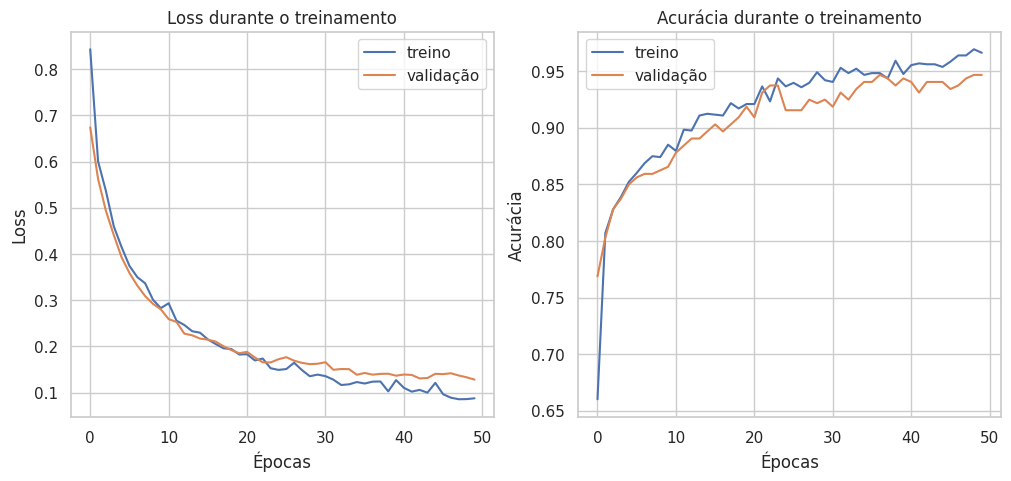

In [60]:
## Perda e acurácia

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(['treino', 'validação'])

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(['treino', 'validação'])

plt.show()


In [24]:
from sklearn.utils.class_weight import compute_class_weight

In [25]:
def create_model(optimizer='adam', dropout_rate=0.3, neurons1=64, neurons2=32):
    """
    Função para criar e compilar o modelo Keras.
    Parâmetros são expostos para otimização com GridSearchCV.
    """
    model = Sequential([
        # Camada de entrada/primeira camada densa
        Dense(neurons1, activation='relu', input_dim=X_train.shape[1]),
        Dropout(dropout_rate),

        # Segunda camada densa
        Dense(neurons2, activation='relu'),
        Dropout(dropout_rate),

        # Camada de saída (Número de classes)
        Dense(y_cat.shape[1], activation='softmax')
    ])

    # Compilação
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Avaliando o desequilibrio de classes.

In [54]:
##pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2


In [56]:
##pip install scikit-learn==1.3.2

In [80]:
# ===========================================================
# 12. Tratamento do Desequilíbrio de Classes e Otimização

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# 12.1. Cálculo dos Pesos de Classe (Class Weight)
# Continuamos usando as labels inteiras para o cálculo dos pesos.
y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("\nPesos de Classe Calculados:", class_weight_dict)


# 12.2. Envoltório KerasClassifier e GridSearch
# O KerasClassifier usará os pesos e, graças à nova função de perda,
# aceitará os rótulos de inteiros do GridSearch.

keras_model = KerasClassifier(
    model=create_model,
    verbose=0,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

# Define a grade de hiperparâmetros
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.2, 0.4],
    'model__neurons1': [64, 128],
    'epochs': [50, 75]
}

# Configuração do Grid Search com 3-fold Cross-Validation
grid = GridSearchCV(
    estimator=keras_model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='accuracy',
    verbose=1
)

print("\nIniciando Grid Search...")
# CORREÇÃO FINAL: Usamos y_train_labels (inteiros) para o fit.
# A nova função de perda (sparse) resolve a incompatibilidade interna.
grid_result = grid.fit(X_train, y_train_labels)


# 12.3. Resumo dos Resultados do Grid Search

print("\n=========================================================")
print("  RESULTADOS DO GRID SEARCH (MODELO OTIMIZADO)")
print("=========================================================")
print(f"Melhor Acurácia na Validação: {grid_result.best_score_:.4f}")
print("Melhores Hiperparâmetros:", grid_result.best_params_)

best_model_optimized = grid_result.best_estimator_


# 12.4. Avaliação do Melhor Modelo no Conjunto de Teste

print("\n12.4. Avaliação do Modelo Otimizado no Conjunto de Teste")

y_pred_optimized = best_model_optimized.predict(X_test)

# Converte de volta para as labels originais para o classification_report
y_pred_optimized_classes = y_pred_optimized.flatten()
y_test_classes_optimized = np.argmax(y_test, axis=1)

accuracy_optimized = accuracy_score(y_test_classes_optimized, y_pred_optimized_classes)

print("\nACCURACY DO MODELO OTIMIZADO:", accuracy_optimized, "\n")
print(classification_report(y_test_classes_optimized, y_pred_optimized_classes, target_names=le.classes_))

# 13. Comparação Final de Desempenho

print("\n=========================================================")
print("  COMPARAÇÃO FINAL DE DESEMPENHO (ACCURACY NO TESTE)")
print("=========================================================")

# Acurácia do modelo ANTERIOR do seu código original
accuracy_original = accuracy_score(y_test_classes, y_pred_classes)

print(f"Modelo 1 (Original, Sem Otimização): {accuracy_original:.4f}")
print(f"Modelo 2 (Otimizado, Com Class Weight e Grid Search): {accuracy_optimized:.4f}")


Pesos de Classe Calculados: {0: 6.504065040650406, 1: 2.0592020592020592, 2: 0.4236166269526079}

Iniciando Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  RESULTADOS DO GRID SEARCH (MODELO OTIMIZADO)
Melhor Acurácia na Validação: 0.9456
Melhores Hiperparâmetros: {'epochs': 75, 'model__dropout_rate': 0.2, 'model__neurons1': 128, 'optimizer': 'adam'}

12.4. Avaliação do Modelo Otimizado no Conjunto de Teste

ACCURACY DO MODELO OTIMIZADO: 0.94 

              precision    recall  f1-score   support

        High       0.75      0.60      0.67        20
         Low       0.93      0.88      0.90        65
      Medium       0.95      0.97      0.96       315

    accuracy                           0.94       400
   macro avg       0.88      0.82      0.84       400
weighted avg       0.94      0.94      0.94       400


  COMPARAÇÃO FINAL DE DESEMPENHO (ACCURACY NO TESTE)
Modelo 1 (Original, Sem Otimização): 0.9325
Modelo 2 (Otimizado, Com Class Weight e Grid Search): 0.9400


In [75]:
best_model_optimized = grid_result.best_estimator_


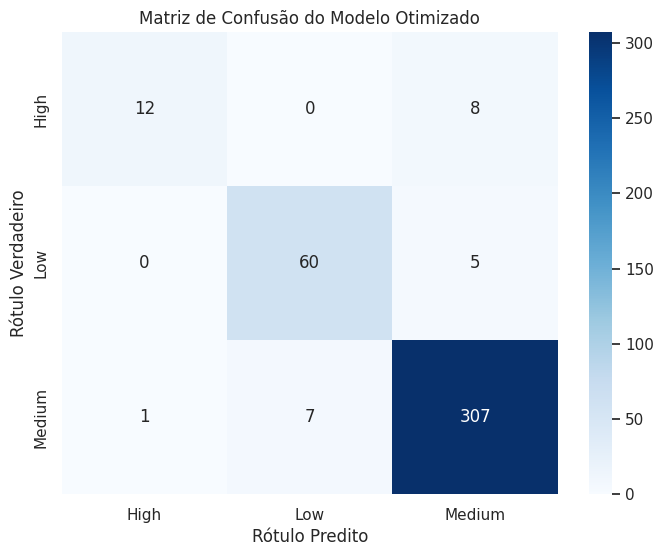


Análise Visual: A Matriz de Confusão mostra quantos casos de cada risco foram classificados corretamente (diagonal principal).


In [34]:
## matriz de confusão

# 14. Matriz de Confusão para Visualização do Modelo Otimizado
#

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_optimized = confusion_matrix(y_test_classes_optimized, y_pred_optimized_classes)
labels = le.classes_ # Nomes das classes: Low, Medium, High

plt.figure(figsize=(8, 6))
#
sns.heatmap(
    cm_optimized,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Matriz de Confusão do Modelo Otimizado')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()

print("\nAnálise Visual: A Matriz de Confusão mostra quantos casos de cada risco foram classificados corretamente (diagonal principal).")

In [61]:
## testar novas arquiteturas e funções de ativação

# 11. Função para criar o modelo (Revisada para Ativação)

# Certifique-se de que a variável X_train está acessível aqui
def create_model(optimizer='adam', dropout_rate=0.3, neurons1=64, neurons2=32, activation='relu'):
    """
    Função para criar e compilar o modelo Keras.
    Adiciona 'activation' como um parâmetro otimizável.
    """
    model = Sequential([
        # Camada de entrada/primeira camada densa
        Dense(neurons1, activation=activation, input_dim=X_train.shape[1]),
        Dropout(dropout_rate),

        # Segunda camada densa
        Dense(neurons2, activation=activation), # Usa a ativação variável
        Dropout(dropout_rate),

        # Camada de saída (Não muda, deve ser 'softmax')
        Dense(y_cat.shape[1], activation='softmax')
    ])

    # Compilação
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy', # MANTIDA a correção do erro anterior
        metrics=['accuracy']
    )
    return model

In [63]:
# 12.5. Otimização 2: Explorando Ativação e Arquitetura

# As variáveis y_train_labels e class_weight_dict permanecem as mesmas
# do bloco 12.1 anterior.

# Inicializa o KerasClassifier
keras_model_v2 = KerasClassifier(
    model=create_model,
    verbose=0,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

# Define a NOVA grade de hiperparâmetros
param_grid_v2 = {
    # Testar otimizadores e taxas de aprendizado comuns
    'optimizer': ['adam', 'sgd'],

    # Testar funções de ativação populares
    'model__activation': ['relu', 'tanh', 'elu'],

    # Testar arquitetura: 64 neurônios na 1ª e 16 ou 32 na 2ª
    'model__neurons1': [64],
    'model__neurons2': [16, 32],

    # Manter a taxa de dropout dentro de um intervalo razoável
    'model__dropout_rate': [0.2, 0.4]

    # Total de combinações: 2 * 3 * 1 * 2 * 2 = 24 combinações
}

# Configuração do Grid Search (mantemos o StratifiedKFold)
grid_v2 = GridSearchCV(
    estimator=keras_model_v2,
    param_grid=param_grid_v2,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='accuracy',
    verbose=1
)

print("\nIniciando Grid Search V2 (Ativação e Arquitetura)...")
grid_result_v2 = grid_v2.fit(X_train, y_train_labels)


# 12.6. Resumo e Avaliação do Modelo V2

print("\n=========================================================")
print("  RESULTADOS DO GRID SEARCH V2 (ATIV./ARQUIT.)")
print("=========================================================")
print(f"Melhor Acurácia na Validação (V2): {grid_result_v2.best_score_:.4f}")
print("Melhores Hiperparâmetros (V2):", grid_result_v2.best_params_)

best_model_optimized_v2 = grid_result_v2.best_estimator_

print("\n12.7. Avaliação do Melhor Modelo V2 no Conjunto de Teste")

y_pred_optimized_v2 = best_model_optimized_v2.predict(X_test)

y_pred_v2_classes = y_pred_optimized_v2.flatten()

accuracy_optimized_v2 = accuracy_score(y_test_classes_optimized, y_pred_v2_classes)

print("\nACCURACY DO MODELO OTIMIZADO V2:", accuracy_optimized_v2, "\n")
print(classification_report(y_test_classes_optimized, y_pred_v2_classes, target_names=le.classes_))


Iniciando Grid Search V2 (Ativação e Arquitetura)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  RESULTADOS DO GRID SEARCH V2 (ATIV./ARQUIT.)
Melhor Acurácia na Validação (V2): 0.9487
Melhores Hiperparâmetros (V2): {'model__activation': 'tanh', 'model__dropout_rate': 0.2, 'model__neurons1': 64, 'model__neurons2': 32, 'optimizer': 'sgd'}

12.7. Avaliação do Melhor Modelo V2 no Conjunto de Teste

ACCURACY DO MODELO OTIMIZADO V2: 0.975 

              precision    recall  f1-score   support

        High       0.86      0.95      0.90        20
         Low       0.94      0.97      0.95        65
      Medium       0.99      0.98      0.98       315

    accuracy                           0.97       400
   macro avg       0.93      0.97      0.95       400
weighted avg       0.98      0.97      0.98       400



In [64]:
print(best_model_optimized_v2.get_params())


{'model': <function create_model at 0x7eb9f9093380>, 'build_fn': None, 'warm_start': False, 'random_state': None, 'optimizer': 'sgd', 'loss': None, 'metrics': None, 'batch_size': 32, 'validation_batch_size': None, 'verbose': 0, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 50, 'class_weight': {0: 6.504065040650406, 1: 2.0592020592020592, 2: 0.4236166269526079}, 'model__activation': 'tanh', 'model__dropout_rate': 0.2, 'model__neurons1': 64, 'model__neurons2': 32}


In [37]:
best_model_optimized_v2.model_.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,147 (43.55 KB)

 Trainable params: 3,715 (14.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,432 (29.04 KB)

In [ ]:
best_model_optimized_v2 = grid_result.best_estimator_
best_model_optimized_v2.get_params()


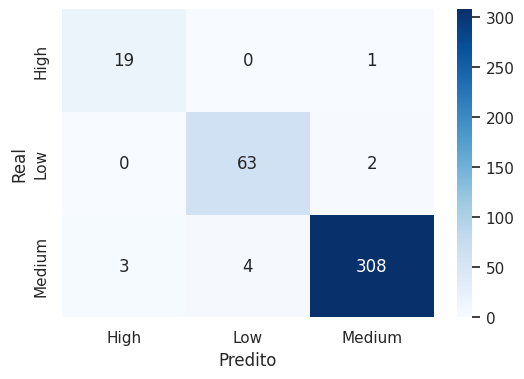

In [67]:

y_pred_v2 = best_model_optimized_v2.predict(X_test)
y_pred_v2 = y_pred_v2.flatten()

y_true_v2 = y_test_classes_optimized

# 3. Matriz de Confusão
cm_v2 = confusion_matrix(y_true_v2, y_pred_v2)

# 4. Plot da Matriz
plt.figure(figsize=(6,4))
sns.heatmap(cm_v2, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


expandindo o param_grid para incluir funções de ativações mais usuais e arquitetura com menos neurônios.

In [36]:
# Melhor Modelo com Dropout Reforçado (0.5)


BEST_OPTIMIZER = 'adam'
BEST_ACTIVATION = 'relu'
BEST_NEURONS1 = 128
BEST_NEURONS2 = 32
BEST_EPOCHS = 75
NEW_DROPOUT_RATE = 0.5    # Aumento do Dropout para regularização extra

print(f"\nConstruindo Modelo A com Dropout Reforçado ({NEW_DROPOUT_RATE})...")

# Criação do modelo (usando a função create_model e os melhores parâmetros)
model_a = create_model(
    optimizer=BEST_OPTIMIZER,
    dropout_rate=NEW_DROPOUT_RATE,  # Novo valor de Dropout
    neurons1=BEST_NEURONS1,
    neurons2=BEST_NEURONS2,
    activation=BEST_ACTIVATION
)

# Treinamento do Modelo A (com os pesos de classe e o número de épocas otimizado)
history_a = model_a.fit(
    X_train, y_train_labels, # Usando y_train_labels (inteiros) e sparse_categorical_crossentropy
    epochs=BEST_EPOCHS,
    batch_size=32,
    verbose=0,
    validation_split=0.2,
    class_weight=class_weight_dict # Manter o tratamento do desequilíbrio
)

# Avaliação do Modelo A
y_pred_a = model_a.predict(X_test)
y_pred_a_classes = np.argmax(y_pred_a, axis=1)

accuracy_a = accuracy_score(y_test_classes_optimized, y_pred_a_classes)

print("\n--- Resultados do Modelo A (Dropout Reforçado) ---")
print(f"ACCURACY (Teste): {accuracy_a:.4f}\n")
print(classification_report(y_test_classes_optimized, y_pred_a_classes, target_names=le.classes_))


Construindo Modelo A com Dropout Reforçado (0.5)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

--- Resultados do Modelo A (Dropout Reforçado) ---
ACCURACY (Teste): 0.9275

              precision    recall  f1-score   support

        High       0.59      0.65      0.62        20
         Low       0.89      0.91      0.90        65
      Medium       0.96      0.95      0.95       315

    accuracy                           0.93       400
   macro avg       0.81      0.84      0.82       400
weighted avg       0.93      0.93      0.93       400



In [37]:
# Melhor Modelo com Ativação Sigmoid

SIGMOID_ACTIVATION = 'sigmoid' # Nova função de ativação
BEST_OPTIMIZER = 'adam'    # Exemplo

print(f"\nConstruindo Modelo B com Ativação Sigmoid...")

# Criação do modelo (mudando apenas a ativação para Sigmoid)
model_b = create_model(
    optimizer=BEST_OPTIMIZER,
    dropout_rate=0.3, # Usando um dropout padrão
    neurons1=BEST_NEURONS1,
    neurons2=BEST_NEURONS2,
    activation=SIGMOID_ACTIVATION # Nova Ativação
)

# Treinamento do Modelo B
history_b = model_b.fit(
    X_train, y_train_labels,
    epochs=BEST_EPOCHS,
    batch_size=32,
    verbose=0,
    validation_split=0.2,
    class_weight=class_weight_dict
)

# Avaliação do Modelo B
y_pred_b = model_b.predict(X_test)
y_pred_b_classes = np.argmax(y_pred_b, axis=1)

accuracy_b = accuracy_score(y_test_classes_optimized, y_pred_b_classes)

print("\n--- Resultados do Modelo B (Ativação Sigmoid) ---")
print(f"ACCURACY (Teste): {accuracy_b:.4f}\n")
print(classification_report(y_test_classes_optimized, y_pred_b_classes, target_names=le.classes_))


Construindo Modelo B com Ativação Sigmoid...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

--- Resultados do Modelo B (Ativação Sigmoid) ---
ACCURACY (Teste): 0.9250

              precision    recall  f1-score   support

        High       0.62      0.80      0.70        20
         Low       0.86      0.91      0.88        65
      Medium       0.97      0.94      0.95       315

    accuracy                           0.93       400
   macro avg       0.81      0.88      0.84       400
weighted avg       0.93      0.93      0.93       400



In [ ]:
## Os ultimos dois modelos não mostraram resultados superiores
